This notebook was used to create the different graphs based on the requirements provided in the course descriptions. 

## Import the libraries :

In [1]:
# Useful starting lines
%matplotlib inline
import os
import numpy as np
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
import re
import networkx as nx
import itertools
import pygsp
from pygsp import graphs, filters, plotting
import pickle 


plt.rcParams['figure.figsize'] = (17, 5)
plotting.BACKEND = 'matplotlib'

%load_ext autoreload
%autoreload 2

In [2]:
courses=pd.read_pickle("../data/cleaned_courses_STI.pickle")
courses.head()

,AcademicYear,CourseTitleFR,CourseTitleEN,ProfessorSCIPERs,AssistantSCIPERs,KeyWords_FR,KeyWords_EN,StudyPlans,Requirements,Summary_Concepts_Contents_EN,Summary_Concepts_Contents_FR
CourseCode,,,,,,,,,,,
BIOENG-404,2016-2017,Analysis and modelling of locomotion,NaN,220184;115955;104385,266358;223203;170511;255602;181161;267756;210551,"[neurophysiology, motor system, l ocomotion, k...","[neurophysiology, motor system, locomotion, ki...",EDNE -; SV,[],"[neuroprosthetics, and link to biped robot, ga...","[la biomécanique, la modélisation numérique, l..."
BIOENG-430,2016-2017,Introduction to cellular and molecular biotech...,NaN,162095,NaN,"[biotechnologie, expression génique, transgénè...","[biotechnology, gene expression, trasngenesis,...",CGC; Mineur : Biotechnologie -,[],"[, the course present comparatively several to...",[soulignant la réduction de l'impact environne...
BIOENG-433,2016-2017,Biotechnology lab (for CGC),NaN,110882,252599;253981;273636;273637;243036;273638;2427...,[],[],CGC; Mineur : Biotechnologie -,[BIOENG-437],[they purify the recombinant protein and chara...,[ce cours donnera l'opportunité de se familiar...
BIOENG-437,2016-2017,Pharmaceutical biotechnology,NaN,110882,NaN,[],[],CGC; Mineur : Biotechnologie -,[],[the course will try to trace back the think a...,[the course will try to trace back the think a...
BIOENG-442,2016-2017,Biomaterials,NaN,106911;254787,243036;260304;253981;266152,[],"[cell, extracellular matrix, tissue, regenerat...",CGC; Mineur : Neuroprosthétiques -; Mineur : T...,[],[this course cover the fundamental concept beh...,[ce cours couvre le concept fondamentaux sur l...


In [3]:
# Index for the courses
courses_index_dict=dict(zip(courses.index, np.arange(len(courses.index))))

## 1. Functions: weight matrix and graph construction

The following functions are used later on make our analysis on the requirements. It includes the following processes:
    - Compute the weight matrix thanks to a dictionnary where the keys are course codes and the values are the topics (i.e. Professors or Studyplans).
    - Compute a weight matrix thanks to a dictionnary where the keys are the topics and the values are the course codes.
    - Compute a graph based on its weight matrix.
    - Reshape a weight matrix by adding courses that did not have requirements.

In [4]:
# Argument 1: Dictionary course -> topics
# Return: weight matrix
def compute_weight_matrix_ct(courses_dict):
    # Initialize the weight matrix and the list of the values.
    weight_mat=np.zeros((len(courses_dict),len(courses_dict)))
    values_for_each_course = list(courses_dict.values())
    
    # Create a list containing all the unique values.
    unique_values = []
    for i in range(0,len(values_for_each_course)):
        unique_values.extend(values_for_each_course[i])
    unique_values = list(set(unique_values))
    
    # Loop on the values: Find every courses that have the same value v. Then add a weight between them.
    for i in range(0,len(unique_values)):
        # Variable to store the index of the courses that have the value i in common
        courses_index_with_value_i = []
        for j,lst in enumerate(values_for_each_course):
            for k,value in enumerate(lst):
                if value == unique_values[i]:
                    courses_index_with_value_i.append(j)
        # Add weight between the courses.
        for j in range(0,len(courses_index_with_value_i)):
            for k in range(j+1,len(courses_index_with_value_i)):
                weight_mat[courses_index_with_value_i[j],courses_index_with_value_i[k]] += 1
                weight_mat[courses_index_with_value_i[k],courses_index_with_value_i[j]] += 1        
    return weight_mat

In [5]:
# Argument 1: dictionary topic -> course (topic = StudyPlans or Professors..)
# Argument 2 (optional): dictionary course -> index
# Argument 3 (optional): weight added for one link between two edges. Default = 1
# Return tuple: (weight_matrix) if argument 2 given
#               (weight_matrix, dictionary course -> index) if argument 2 not given

def compute_weight_matrix_tc(*args):
    # Initialize the dictionaries depending on the inputs
    topic_dict = args[0]
    if(len(args) > 1):
        courses_index_dict = args[1]
    else:
        # The index have to be determined
        unique_courses = []
        courses_index_dict = {}
        # Find each courses
        for i in range(0,len(list(topic_dict.values()))):
            unique_courses.extend(list(topic_dict.values())[i])
        unique_courses = list(set(unique_courses))
        # Create dictionary courses -> index
        courses_index_dict=dict(zip(unique_courses, np.arange(len(unique_courses))))
    # Initialize the weight matrix
    weight_mat=np.zeros((len(courses_index_dict),len(courses_index_dict)))
    # Define the weights for each edges
    if(len(args) > 2):
        w = args[2]
    else:
        w = 1      
    # For all topics, find links between courses
    for topic in topic_dict.keys():
        for course1, course2 in itertools.combinations(topic_dict[topic], 2):
            weight_mat[courses_index_dict[course1],courses_index_dict[course2]]+=w
            weight_mat[courses_index_dict[course2],courses_index_dict[course1]]+=w
    # Return the weight matrix and the index dictionary if it was not given as an input.
    if(len(args) > 1):
        return weight_mat
    else:
        return weight_mat, courses_index_dict

In [6]:
def compute_graph(weight_mat):
    # Create the graph: nx -> weight matrix
    Graph = nx.from_numpy_matrix(weight_mat)
    # Initialize the plot and the position of the nodes.
    plt.figure(1,figsize=(16,16)) 
    pos = nx.spring_layout(Graph)
    # Draw and plot the nodes, labels and edges.
    nx.draw_networkx_nodes(Graph, pos, cmap=plt.get_cmap('jet'))
    nx.draw_networkx_labels(Graph, pos)
    nx.draw_networkx_edges(Graph, pos)
    plt.show()
    return Graph

In [7]:
# Reshape the weight matrix:
# - index_weight: index of the courses of the actual weight matrix
# - index_courses: index of all the courses wanted in the weight matrix
def reshape_weight_matrix(weight_matrix, index_weight, index_courses):
    result_weight_matrix = np.zeros((len(index_courses),len(index_courses)))
    for key in index_courses.keys():
        # If the course is taken into account in the actual matrix, add it to the new one
        if(key in index_weight.keys()):
            for key2 in index_weight.keys():
                # And if the course exists in the final list, add it to the new matrix
                if(key2 in index_courses.keys()):
                    result_weight_matrix[index_courses[key],index_courses[key2]] = weight_matrix[index_weight[key],index_weight[key2]]
                    result_weight_matrix[index_courses[key2],index_courses[key]] = weight_matrix[index_weight[key2],index_weight[key]]
    return result_weight_matrix

## 2. Requirements of the same course linked together

Creation of the graph obtained by linking the courses required for the same lecture.

In [8]:
# Creation of the dictionary course -> requirements
dict_requirements_same_course = courses['Requirements'].to_dict()
# Delete the entries that have less than 2 requirements
new_dict = {}
for key in dict_requirements_same_course.keys():
    if (len(list(dict_requirements_same_course[key])) > 1):
        new_dict[key] = dict_requirements_same_course[key]
dict_requirements_same_course = new_dict

In [9]:
weight_requirements_same_course, index_requirements_same_course = compute_weight_matrix_tc(dict_requirements_same_course)
#weight_requirements_same_course = reshape_weight_matrix(weight_requirements_same_course,index_requirements_same_course,courses_index_dict)

In [10]:
# Number of courses that have been linked
len(index_requirements_same_course)

111

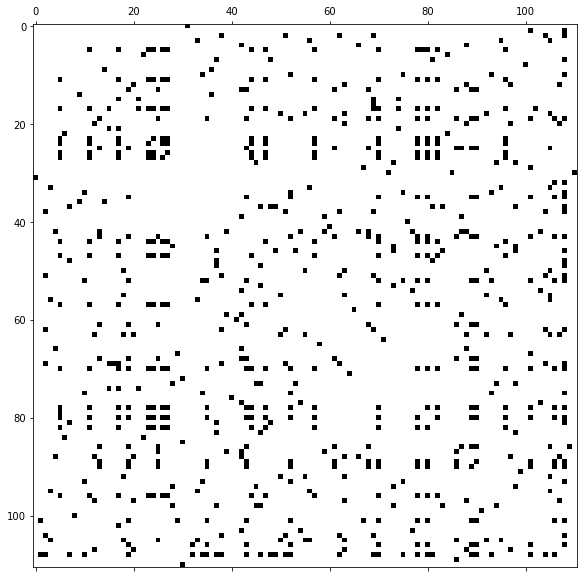

In [11]:
plt.figure(1,figsize=(10,10))
plt.spy(weight_requirements_same_course)

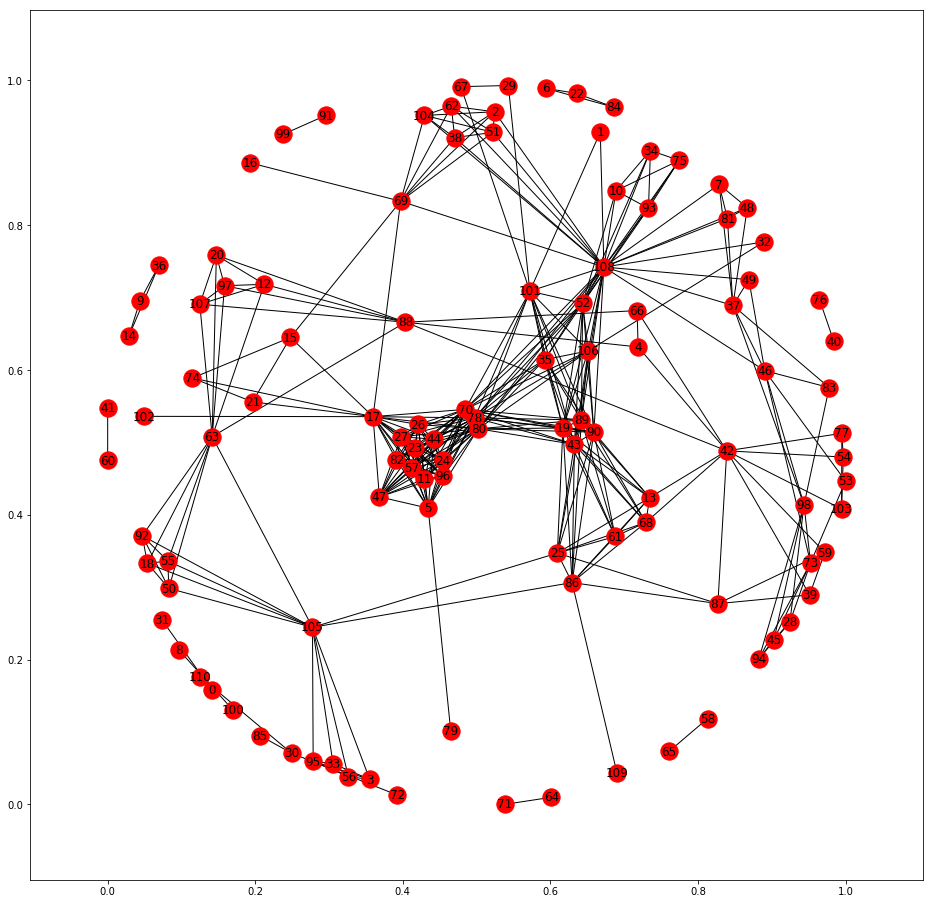

In [12]:
graph_requirements_same_course = compute_graph(weight_requirements_same_course)

## 3.  Courses linked to their requirements

Creation of the graph obtained by linking a course to its requirements.

In [13]:
# Creation of the dictionary course+requirement -> course, requirement
dict_course_to_requirement = courses['Requirements'].to_dict()
new_dict = {}
for key in dict_requirements_same_course.keys():
    if (len(list(dict_requirements_same_course[key])) > 0):
        for value in dict_requirements_same_course[key]:
            new_dict[key+"+"+value] = [key]
            new_dict[key+"+"+value] += [value]
dict_course_to_requirement = new_dict

In [14]:
weight_course_to_requirement, index_course_to_requirement = compute_weight_matrix_tc(dict_course_to_requirement)
#weight_course_to_requirement = reshape_weight_matrix(weight_course_to_requirement,index_course_to_requirement,courses_index_dict)

In [15]:
# Number of courses that have been linked
len(index_course_to_requirement)

155

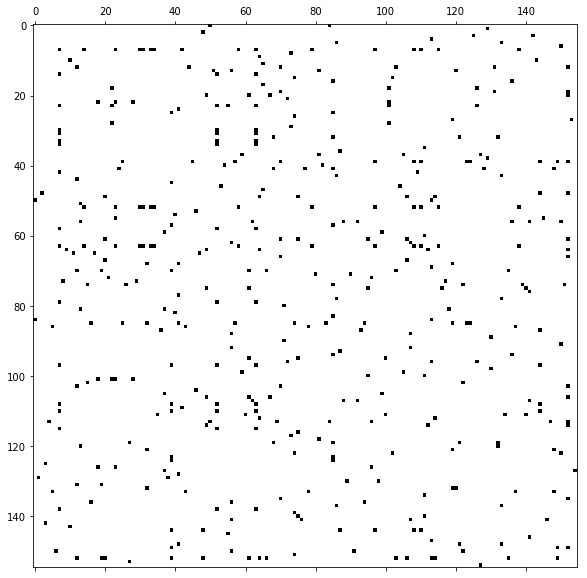

In [16]:
plt.figure(1,figsize=(10,10))
plt.spy(weight_course_to_requirement)

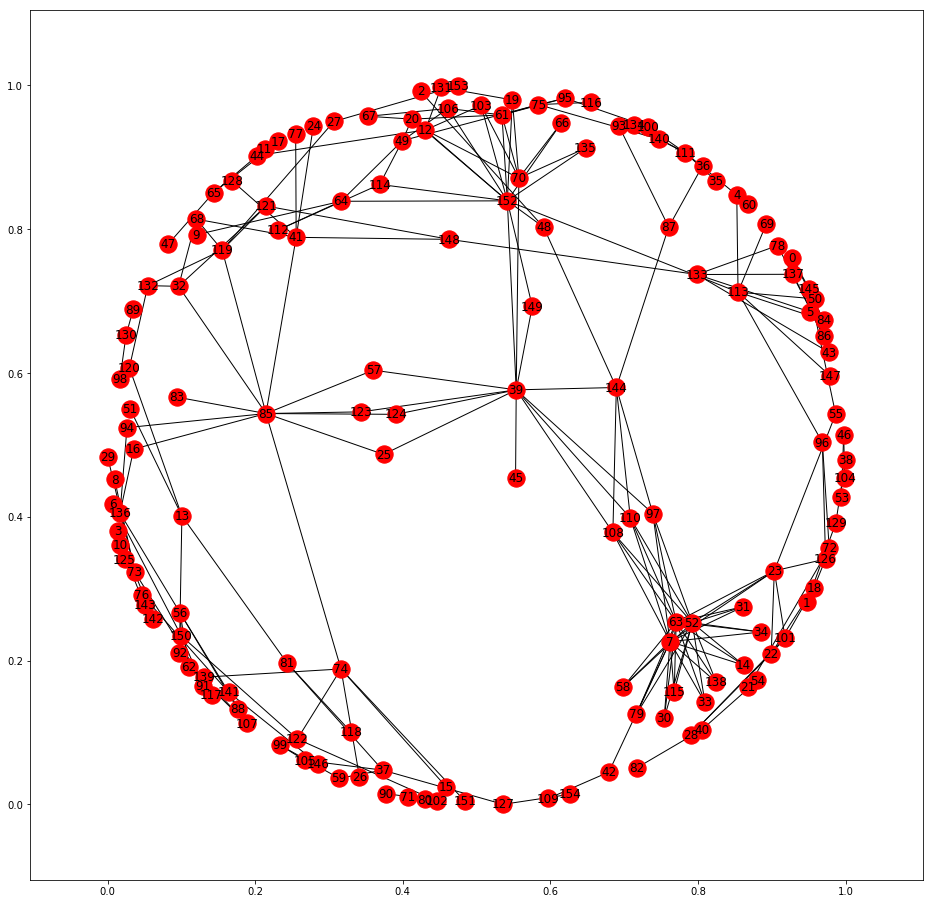

In [17]:
graph_course_to_requirement = compute_graph(weight_course_to_requirement)

## 4. Courses that have the same requirements linked together

Creation of the graph obtained by linking the courses that have the same requirements together.

In [18]:
# Creation of the dictionary requirement -> courses
dict_course_same_requirements = courses['Requirements'].to_dict()

new_dict = {}
for key in dict_course_same_requirements.keys():
    for value in dict_course_same_requirements[key]:
        if(value in new_dict):
            new_dict[value] += [key]
        else:
            new_dict[value] = [key]
dict_course_same_requirements = new_dict

In [19]:
weight_course_same_requirements, index_course_same_requirements = compute_weight_matrix_tc(dict_course_same_requirements)
#weight_course_same_requirements = reshape_weight_matrix(weight_course_same_requirements,index_course_same_requirements,courses_index_dict)

In [20]:
# Number of courses that have been linked
len(index_course_same_requirements)

109

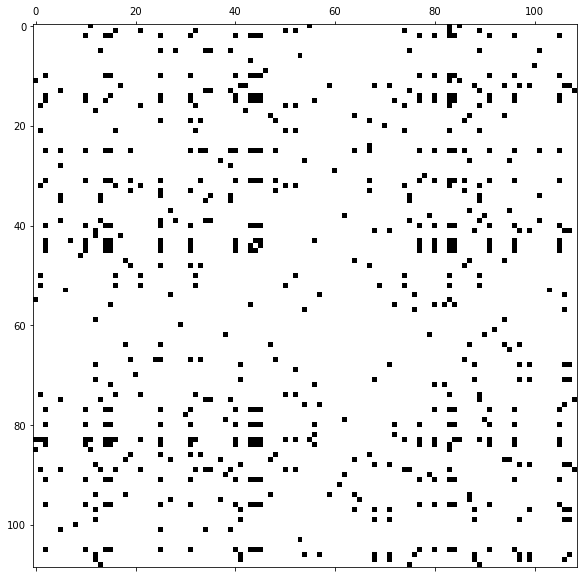

In [21]:
plt.figure(1,figsize=(10,10))
plt.spy(weight_course_same_requirements)

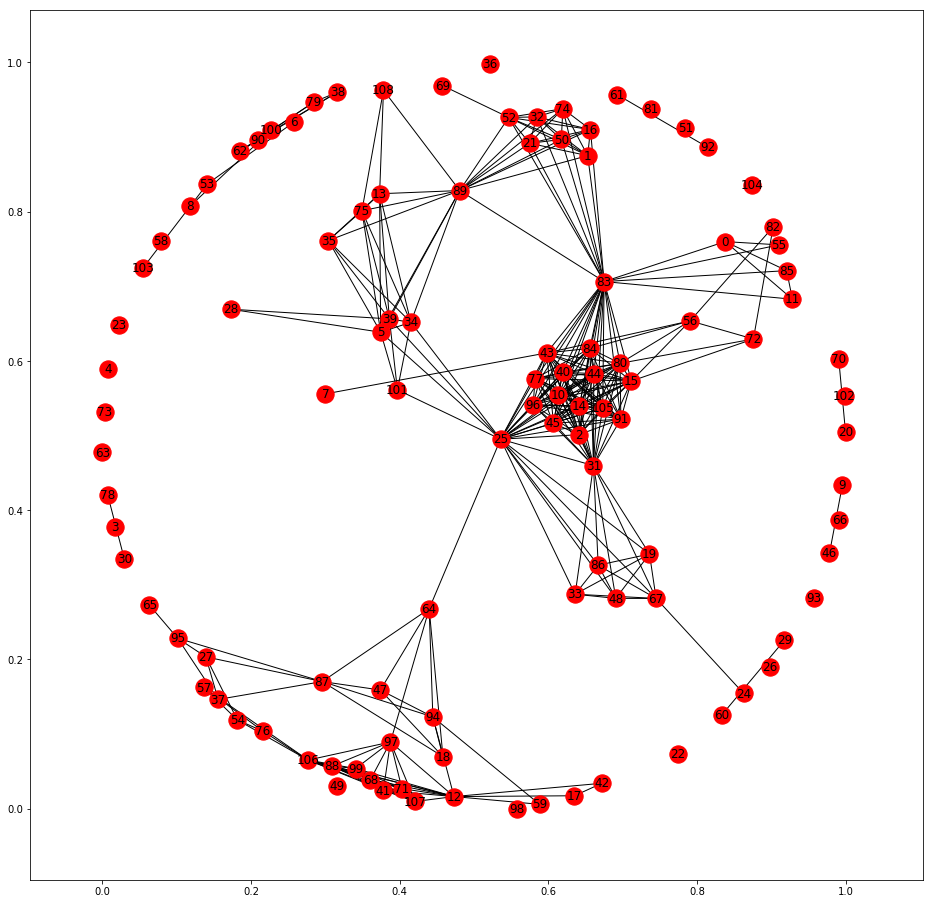

In [22]:
graph_course_same_requirements = compute_graph(weight_course_same_requirements)

## 5. Reshape the weight matrices

In this part we reshape the weight matrices of the 3 parts presented before so every courses are taking into account. It means that even if a course did not have requirement, it will appear in the weight matrix.

In [23]:
weight_requirements_same_course = reshape_weight_matrix(weight_requirements_same_course,index_requirements_same_course,courses_index_dict)

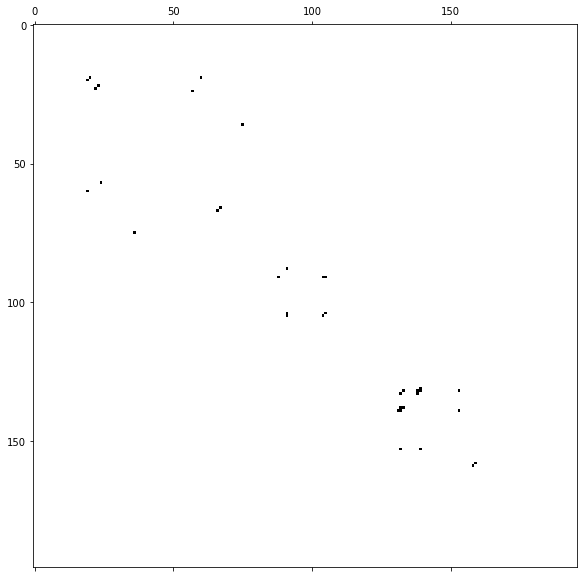

In [24]:
plt.figure(1,figsize=(10,10))
plt.spy(weight_requirements_same_course)

In [25]:
weight_course_to_requirement = reshape_weight_matrix(weight_course_to_requirement,index_course_to_requirement,courses_index_dict)

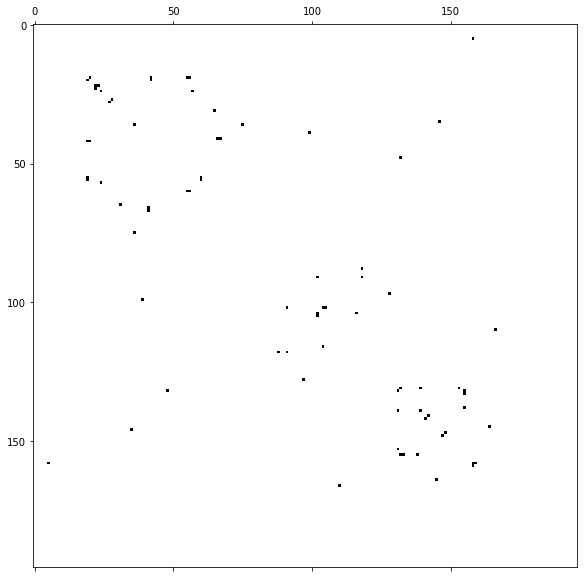

In [26]:
plt.figure(1,figsize=(10,10))
plt.spy(weight_course_to_requirement)

In [27]:
weight_course_same_requirements = reshape_weight_matrix(weight_course_same_requirements,index_course_same_requirements,courses_index_dict)

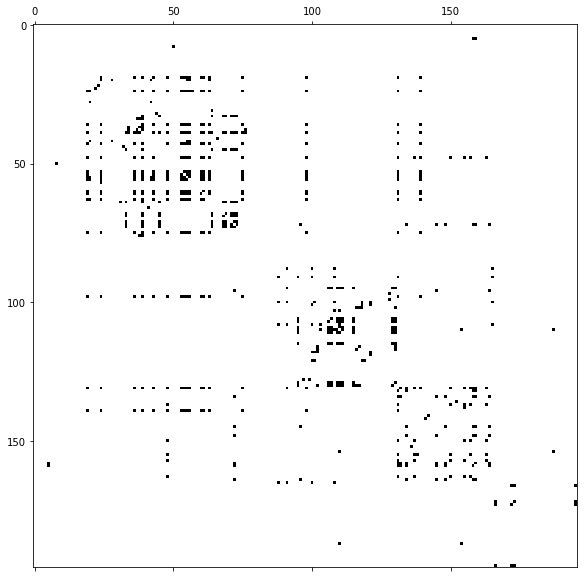

In [28]:
plt.figure(1,figsize=(10,10))
plt.spy(weight_course_same_requirements)

## Saving the weight matrices into files.

In [29]:
pkl_file = open(os.path.join(os.getcwd(), "Graphs","req_course_same_req_graph_STI.pkl"), "wb")
pickle.dump(weight_requirements_same_course, pkl_file)
pkl_file.close()

In [30]:
pkl_file = open(os.path.join(os.getcwd(), "Graphs","req_course_to_req_graph_STI.pkl"), "wb")
pickle.dump(weight_course_to_requirement, pkl_file)
pkl_file.close()

In [31]:
pkl_file = open(os.path.join(os.getcwd(), "Graphs","req_same_course_graph_STI.pkl"), "wb")
pickle.dump(weight_course_same_requirements, pkl_file)
pkl_file.close()